In [1]:
import warnings
import sklearn.metrics as metrics
from utility import split_sequence, plot_history
from dataset import suny_international
warnings.filterwarnings("ignore")


In [2]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [3]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import LSTM
from keras.layers import Dense,Input

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=(10, 5))

In [5]:
def vanilla_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
n_steps=20
n_features= 1
n_forward = 6

In [7]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [8]:
df=suny_international.load_data()['GHI']

In [9]:
y = df.resample('D').mean()
decomposition = sm.tsa.seasonal_decompose(y, model='additive')

In [10]:
nas = decomposition.resid.isna() | decomposition.seasonal.isna() | decomposition.trend.isna() 
decomposition.resid= decomposition.resid[~nas]
decomposition.seasonal= decomposition.seasonal[~nas]
decomposition.trend= decomposition.trend[~nas]

In [11]:
history = {}
model  = {}
components = ('seasonal','trend','resid')
y_pred = {}
y_true = {}

seasonal 7.276632308691259e-13


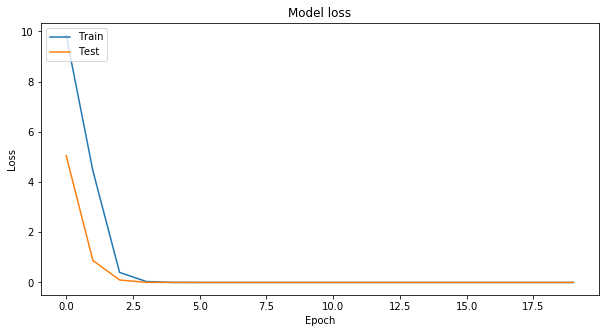

trend 1002.1286379307597


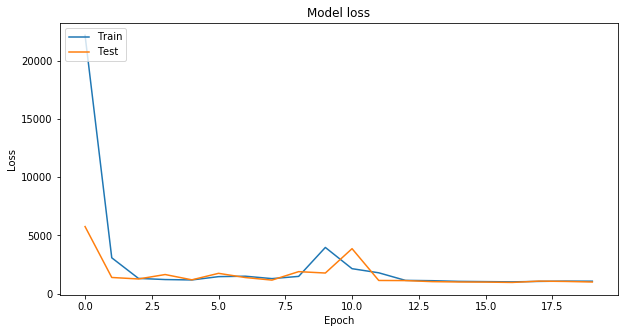

resid 1731.9432137599686


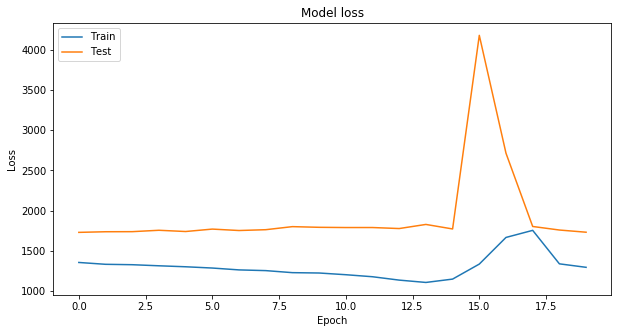

In [13]:
for component in components:
    df_train,df_test = suny_international.train_test_split(getattr(decomposition,component))
    
    X, y = split_sequence(df_train, n_steps,n_forward)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    X_val, y_val = split_sequence(df_test, n_steps,n_forward)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
    y_true[component] = y_val
    model[component]=vanilla_lstm(n_steps, n_features)
    history[component] = model[component].fit(X,y,validation_data=(X_val,y_val),epochs=20,verbose=False)
    y_pred[component] = model[component].predict(X_val)
    model[component].save('models/simple_rnn_' + component + '.h5')
    print(component,history[component].history['val_loss'][-1])
    plot_history(history[component])   

In [14]:
y_pred_test = y_pred['seasonal'] + y_pred['trend'] + y_pred['resid']

In [16]:
y_true_test = y_true['seasonal'] + y_true['trend'] + y_true['resid']
metrics.mean_squared_error(y_true=y_true_test,y_pred=y_pred_test)

2769.2894261494885